In [889]:
#Titanic Survival Prediction
#use the Titanic Survival Dataset to build a classification model to predict 
# whether a passenger survived the sinking of the Titanic, based on
# attributes of each passenger in the data set.

In [890]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import  SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [891]:
#Loading the Titanic dataset using seaborn
titanic=sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


sibsp: defines family relationship in this way:
       sibling = brother, sister, stepbrother, stepsister
       Spouse = husband, wife

In [892]:
print(titanic.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [893]:
print(titanic['sibsp'].value_counts())
print(titanic['sibsp'].unique())
print(titanic['sibsp'].value_counts().sort_index())

sibsp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
[1 0 3 4 2 5 8]
sibsp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: count, dtype: int64


In [894]:
print(titanic.shape)
print(titanic.dtypes)

(891, 15)
survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


In [895]:
print(titanic.count())  #Number of non-null values in each column
print(titanic.count().value_counts())  #How many columns have the same number of non-null values
print(titanic.value_counts().count()) #Counts how many unique rows (combinations of all column values) exist in the dataset.
print(titanic.isnull().sum())

survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64
891    11
889     2
714     1
203     1
Name: count, dtype: int64
181
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


In [896]:
print(titanic[titanic['age'].isnull()].index)

Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
       ...
       832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
      dtype='int64', length=177)


<Axes: >

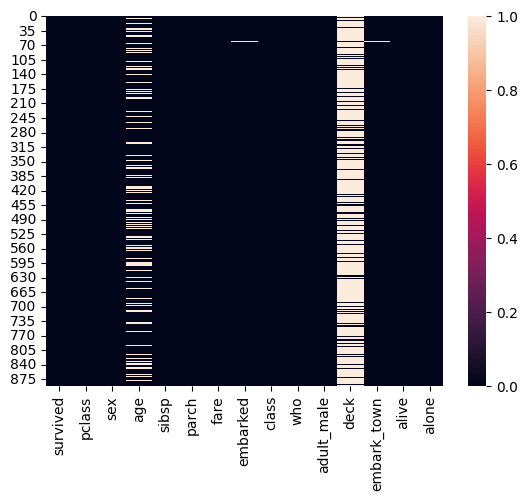

In [897]:
sns.heatmap(titanic.isnull())

In [898]:
print(titanic['sex'].value_counts())
print(titanic[titanic['survived']==1]['sex'].value_counts())

sex
male      577
female    314
Name: count, dtype: int64
sex
female    233
male      109
Name: count, dtype: int64


In [899]:
def bar_chart(feature):
    survived = titanic[titanic['survived']==1][feature].value_counts()
    dead = titanic[titanic['survived']==0][feature].value_counts()
    df= pd.DataFrame([survived, dead])
    df.index = ['survived', 'Dead']
    df.plot(kind='bar', stacked=True, figsize=(12,6))

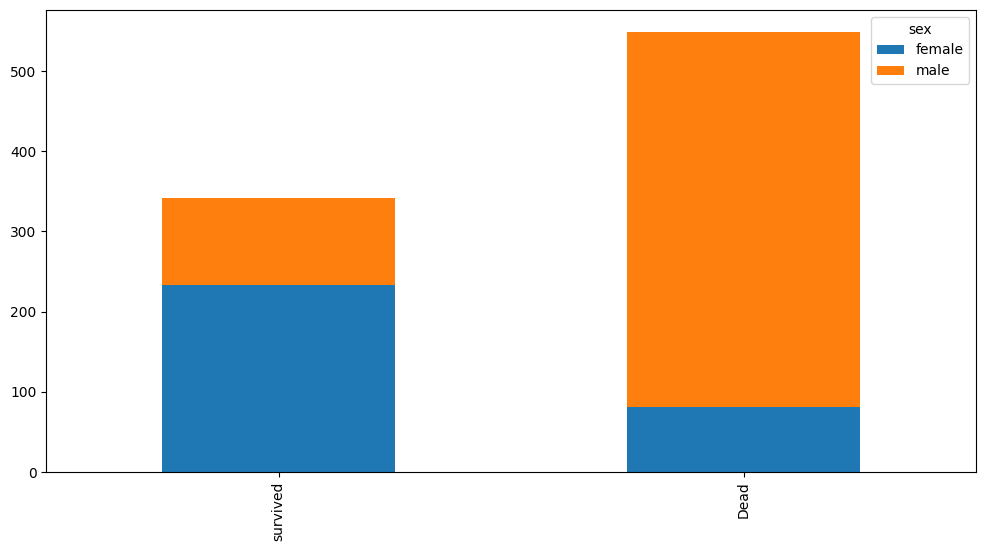

In [900]:
bar_chart('sex')

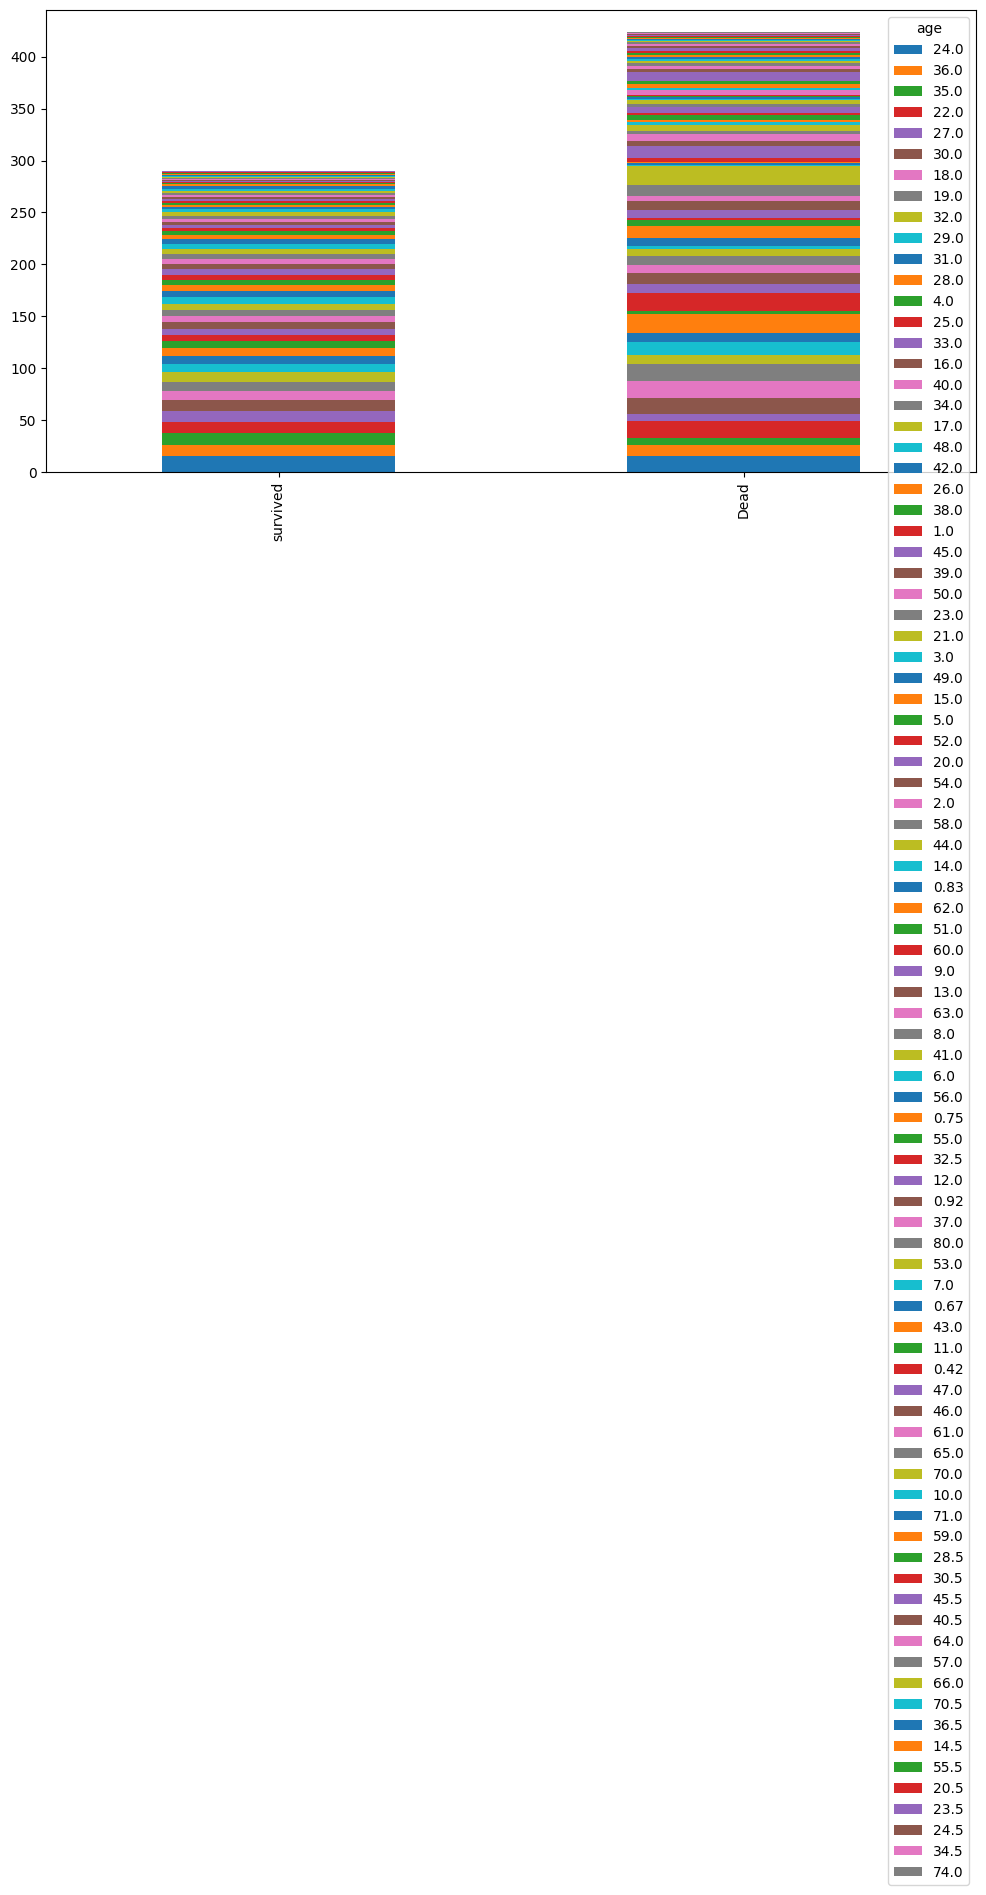

In [901]:
bar_chart('age')

In [902]:
#deck has a lot of missing values so we'll drop it. 
#age has quite a few missing values as well. 
#Although it could be, embarked and embark_town don't seem relevant so we'll drop them as well.
#It's unclear what alive refers to so we'll ignore it.
#survived is our target class variable.

titanic= titanic.drop(columns=["deck","embarked","embark_town"])
y=titanic["survived"]
X = titanic.drop(columns=['survived'])



In [903]:
print(X.dtypes)

pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
class         category
who             object
adult_male        bool
alive           object
alone             bool
dtype: object


In [904]:
print(y.dtypes)

int64


In [905]:
print(y.value_counts())
print(y.value_counts().count())

survived
0    549
1    342
Name: count, dtype: int64
2


In [906]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [907]:
#Define preprocessing transformers for numerical and categorical features
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(numerical_features, categorical_features)

['pclass', 'age', 'sibsp', 'parch', 'fare'] ['sex', 'class', 'who', 'alive']


In [908]:
#Define separate preprocessing pipelines for both feature types
#A pipeline is like a list of steps that the data will go through.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  #SImpleImputer is used to fill in missing values, missing value is replaced with median value of that column
    ('scaler', StandardScaler())   #StandardScaler() makes sure all numerical features:Have a mean of 0
                                                                                    #:Have a standard deviation of 1
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))        #onehotencoder :Converts text categories into numbers that the model can understand.


])

In [909]:
#combining the transformers into a single column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
#A ColumnTransformer allows you to apply different transformers to different columns.
#Applies numerical_transformer to the columns listed in numerical_features
#Applies categorical_transformer to the columns listed in categorical_features

In [910]:
X_processed = preprocessor.fit_transform(X)

In [911]:
#creating a model pipeline
#combining the preprocessing with a RandomForest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [912]:
#defining a parameter grid
#using the grid in a cross validation search to optimize the model
#creating a param_grid dictionary that will be used with GridSearchCV
# to automatically test different combinations of parameters for  RandomForestClassifier to find the best one.
param_grid = {
    'classifier__n_estimators': [50, 100],  #tuning the number of trees in the forest,try both 50 and 100 trees
    'classifier__max_depth': [None, 10, 20], #tuning how deep each decision tree can go
    'classifier__min_samples_split': [2, 5]  #tuning the minimum number of samples required to split a node
}

In [913]:
# Cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

In [914]:
print(X_train.dtypes)

pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
class         category
who             object
adult_male        bool
alive           object
alone             bool
dtype: object


In [915]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
import pandas as pd
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

              precision  recall  f1-score  support
0                   1.0     1.0       1.0    110.0
1                   1.0     1.0       1.0     69.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    179.0
weighted avg        1.0     1.0       1.0    179.0


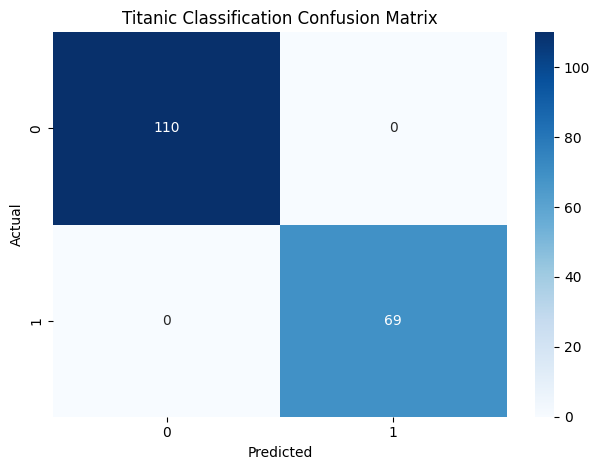

In [916]:
#Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

In [917]:
#tracing back through the trained model to access the one-hot encoded feature names:
model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman', 'alive_no',
       'alive_yes'], dtype=object)

In [918]:
print(X.columns)
# those one-hot encoded columns (like 'sex_female', 'class_Third')
#  are only created during the transformation step inside the pipeline. 
# So unless you transform the data separately, they’re not added to your DataFrame.

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who',
       'adult_male', 'alive', 'alone'],
      dtype='object')


In [919]:
feature_importances = model.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(model.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))
print(feature_names)
print(feature_importances)

['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male', 'class_First', 'class_Second', 'class_Third', 'who_child', 'who_man', 'who_woman', 'alive_no', 'alive_yes']
[0.00555502 0.00669077 0.00321531 0.00101164 0.01636739 0.01657995
 0.02856395 0.00665716 0.00255769 0.01347609 0.00063348 0.03194439
 0.02995409 0.4555598  0.38123326]


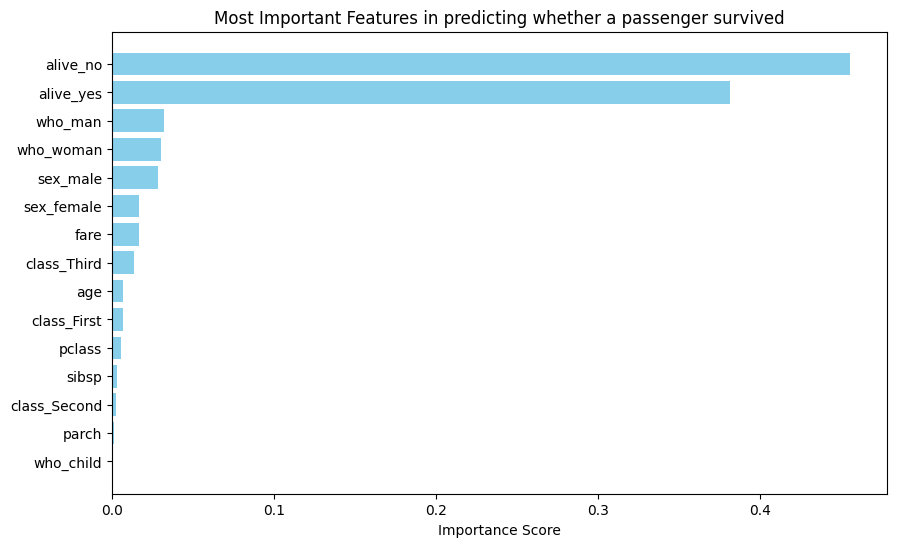


Test set accuracy: 100.00%
         Feature  Importance
13      alive_no    0.455560
14     alive_yes    0.381233
11       who_man    0.031944
12     who_woman    0.029954
6       sex_male    0.028564
5     sex_female    0.016580
4           fare    0.016367
9    class_Third    0.013476
1            age    0.006691
7    class_First    0.006657
0         pclass    0.005555
2          sibsp    0.003215
8   class_Second    0.002558
3          parch    0.001012
10     who_child    0.000633


In [920]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score 
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")
print(importance_df)

In [921]:
#Training a logistic regression model and comparing the performance of the two models
#replacing RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))
model.estimator = pipeline

#Defining a new grid with Logistic Regression
param_grid={"classifier__solver":['liblinear'],    #__ is used to reach into that step and modify its parameters.
            'classifier__penalty':['l1','l2'],
            "classifier__class_weight":[None,'balanced' ]

}
model.param_grid=param_grid
# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

In [922]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        69

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



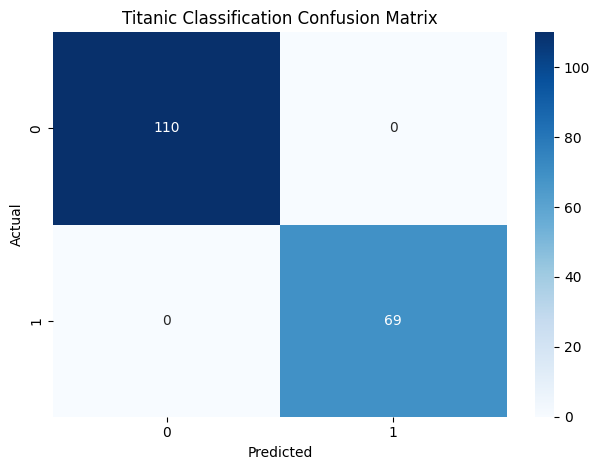

In [923]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt='d')
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [924]:
#Extracting the logistic regression feature coefficients
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

# Combine numerical and categorical feature names
numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

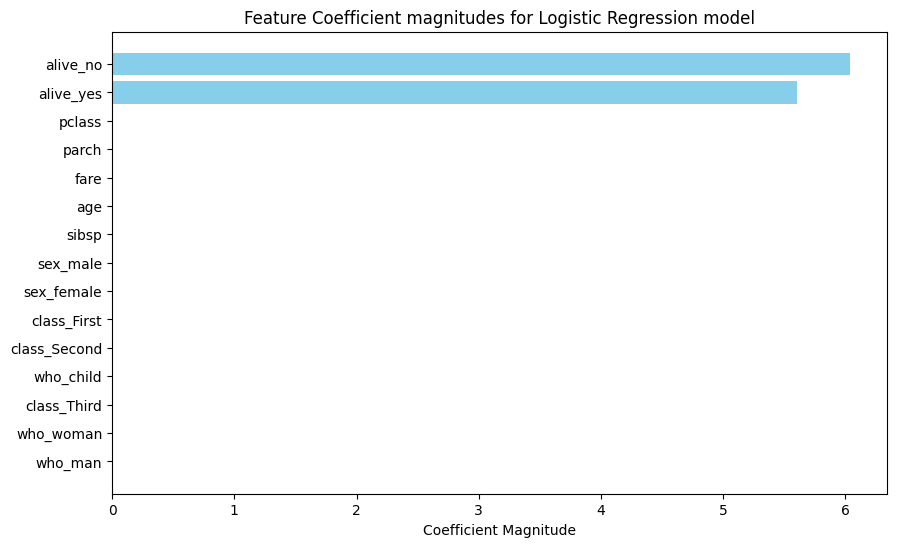


Test set accuracy: 100.00%


In [925]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

In [926]:
#Although the performances of the two models are virtually identical, the features that are important to the two models are very different. This suggests there must be more work to do to better grasp the actual feature importancdes

In [927]:
X_processed = preprocessor.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [928]:
print(X_processed)
print(y_encoded)

[[ 0.82737724 -0.56573646  0.43279337 ...  0.          1.
   0.        ]
 [-1.56610693  0.66386103  0.43279337 ...  1.          0.
   1.        ]
 [ 0.82737724 -0.25833709 -0.4745452  ...  1.          0.
   1.        ]
 ...
 [ 0.82737724 -0.1046374   0.43279337 ...  1.          1.
   0.        ]
 [-1.56610693 -0.25833709 -0.4745452  ...  0.          0.
   1.        ]
 [ 0.82737724  0.20276197 -0.4745452  ...  0.          1.
   0.        ]]
[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 

In [929]:
X_1, X_11, y_1, y_11 = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)


In [930]:
print(X_1.shape)

(712, 15)


In [931]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(5, input_dim=15, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\acer\python workspace\allvenv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [932]:
#compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])

In [933]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 12)             │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195 (780.00 B)

 Trainable params: 195 (780.00 B)

 Non-trainable params: 0 (0.00 B)

In [934]:
# X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else np.array(X_train)
# X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else np.array(X_test)

In [935]:
history = model.fit(X_1, y_1, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6429 - loss: 0.6856 - mean_absolute_error: 0.4927 - val_accuracy: 0.6503 - val_loss: 0.6476 - val_mean_absolute_error: 0.4727
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5868 - loss: 0.6684 - mean_absolute_error: 0.4823 - val_accuracy: 0.6503 - val_loss: 0.6067 - val_mean_absolute_error: 0.4484
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6431 - loss: 0.6240 - mean_absolute_error: 0.4561 - val_accuracy: 0.6573 - val_loss: 0.5639 - val_mean_absolute_error: 0.4197
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6386 - loss: 0.5805 - mean_absolute_error: 0.4270 - val_accuracy: 0.6853 - val_loss: 0.5179 - val_mean_absolute_error: 0.3869
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6887 - loss: 0.5249 - mean_absolute_error: 0.3879 - val_accuracy: 0.7972 - val_loss: 0.4676 - val_mean_absolute_error: 0.3511
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step